# 11 Reprojecting

In this section we will:
- practice merging data frames
- apply `if-else` statements for flow control
- reproject geospatial data 
- create a choropleth map

## About the data

The first dataset we will use is a [list of Arctic communities and their location](https://search.dataone.org/view/doi%3A10.18739%2FA28S4JQ80) @brook_approximate_2023 created by the [Alaska Native Tribal Health Consortium](https://www.anthc.org). This data comess in GeoJSON file with the following attributes:

- **name**: name of Arctic community, 
- **population**: population of Arctic community, as of 2022
- **country**: country that the Arctic community falls within (see dataset metadata for the codes)
- **geoname-id**: numeric codes that uniquely identify all administrative/legal and statistical geographic areas for which the Census Bureau tabulates data

The second dataset is [Natural Earth's medium scale  cultural boundaries data for countries (1:50m)](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). 
We can obtain this dataset by downloading the shapefile. 
[Natural Earth](https://www.naturalearthdata.com) is a public domain dataset with ready-to-use data for creating maps. 

## Import data

We will first import the countries shapefile and adapt it for wrangling purposes:

**EXERCISE** 

The following code has 4 bugs, find them and correct them in order to udpate the data.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', 
                              'data')

# Import countries shapefile
fp = os.path.join(data_folder_fp, 
                  'ne_50m_admin_0_countries', 
                  'ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names

# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)

# Import country names CSV
fp = os.path.join(data_folder_fp, 
                  'country_names', 
                  'country_names.csv')
country_names = pd.read_csv(fp)

In [2]:
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [3]:
communities.head(3)

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)


In [4]:
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


The CRS of the `communities` data frame is EPSG:4326 = WGS 84. All GeoJSON files have that same CRS:

In [5]:
communities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
countries.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The `countries` geodataframe is actually also EGS 84 (EPSG:4326), but interanally they are represented slightly differently and this may cause confusion

In [7]:
countries.crs == communities.crs

False

To be on the safe side, we will reproject to make sure both dataset have the same CRS.

**Reprojecting** means changing coordinate reference systems of your geospatial data.

Changing CRSs in geopandas is super easy using the following:

```python
updated_geodf = geodf.to_crs(new_crs)
```

where: 
- `updated_geodf` = the output of the methos, a new geodataframe with the updated CRS (reprojected)
- `geodf` = the geodataframe that we want to reproject
- `new_crs` = the CRS we want to convert to, can be a CRS object, or a string representing a CRS.

In [8]:
# Reprojecting countries to ensure CRS consistency
countries = countries.to_crs(communities.crs)

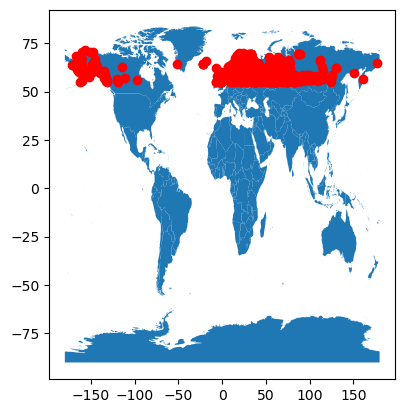

In [9]:
# Plot geospatial data

assert countries.crs == communities.crs

fig, ax = plt.subplots()
countries.plot(ax=ax)
communities.plot(ax=ax, color = 'red')
plt.show()

In [10]:
# Create a dataframe with the number of communities per country
n_comms = (communities.groupby('country')
                    .size()
                    .reset_index(name='n_communities'))

Our goal is to merge the `n_comms` and the `countries` data frame to create a choropleth map

**To merge two data frames they need to have one column in common**

Currently our datasets do not have any columns in common: 

In [11]:
countries.columns

Index(['admin', 'type', 'geometry'], dtype='object')

In [12]:
n_comms.columns

Index(['country', 'n_communities'], dtype='object')

In [13]:
# Find the intersection between countries cols and n_comms cols
set(countries.columns).intersection(n_comms.columns)

set()

## Merge the data

We can use the `country_names` data frame to add the names counties into the `n_comms` data which, in turn, will allow us to merge that data frame with the `country_names`

In [14]:
n_comms.head(2)

,country,n_communities
0,AX,1
1,BY,8


In [15]:
countries.head(2)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."


In [16]:
country_names.head(2)

,country,admin
0,RU,Russia
1,LV,Latvia


To merge:

```python
output_df = pd.merge(left_df,
                    right_df,
                    how=type_of_join,
                     on=columns_to_join)
```

where:
- `output_df` = df resulting from merge
- `left_df` = df on the left side
- `right_df` = df on the right side
- `how` = types of join, innter, left, right...
- `on` = columns to join on, must be present in both data frames

In [17]:
# Join n_comms with country_names
n_comms = pd.merge(n_comms,
                  country_names,
                  how='left',
                  on='country')
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


In [25]:
# Join n_comms with countries
arctic_countries = pd.merge(countries,
                            n_comms,
                            how='inner',
                            on='admin')
    

In [26]:
arctic_countries = arctic_countries.set_index('admin')

In [27]:
arctic_countries

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,98


When doing the inner join we dropped the Aland Islands from the `n_comms` dataset

In [28]:
# Check Alan Islands is nowhere in countries data frame
'Aland Islands' in countries.values

False

In [29]:
arctic_countries.at['Finland', 'n_communities'] += 1

## Choropleth map

<Axes: >

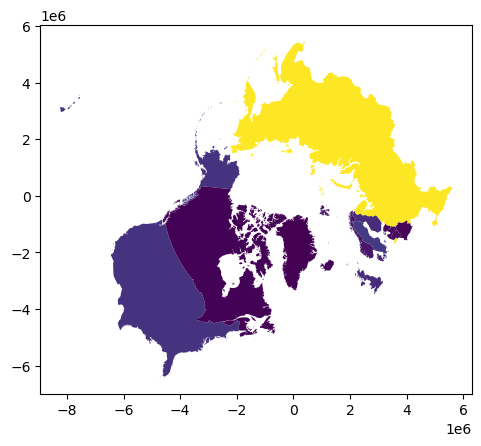

In [32]:
arctic_countries.plot(column='n_communities')

In [31]:
# Reproject to CRS optimized for the Arctic Region
arctic_countries = arctic_countries.to_crs('epsg:3413')

<Axes: >

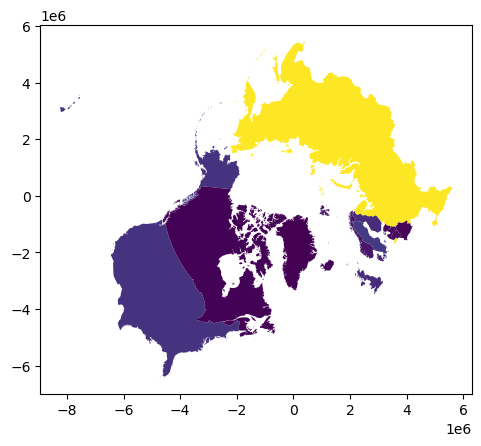

In [33]:
arctic_countries.plot(column='n_communities')